# Global Egg Price Index
This notebook consolidates data processing, visualisation, and normalisation steps for building the Global Egg Price Index.

In [11]:

import pandas as pd
import matplotlib.pyplot as plt

# Set global plot style
plt.style.use("Solarize_Light2")
line_color = "#D2691E"  # Rust/Orange colour
line_width = 1.3


In [13]:
!which python

/Users/eoinoreilly/miniconda3/envs/egg_index/bin/python


## 1. Fetch Latest EUR/USD from Frankfurter API

In [16]:

import requests

url = "https://api.frankfurter.app/1999-01-01..?to=USD&from=EUR"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data["rates"]).T  # Transpose dates as rows
df.index = pd.to_datetime(df.index)
df.columns = ["EUR_USD"]

# Convert to monthly average
df_monthly = df.resample("ME").mean()

# Save to CSV
df_monthly.to_csv("../data/rates/eur_usd.csv")
print(df_monthly.head())


             EUR_USD
1999-01-31  1.160775
1999-02-28  1.120725
1999-03-31  1.087400
1999-04-30  1.069775
1999-05-31  1.058820


In [ ]:
## 2. Load in data

In [17]:
# Load the original CSV
file_path = "../data/usa_data/egg_price_per_dozen_usa.csv"
df = pd.read_csv(file_path)

# Melt the dataframe to long format
df_long = df.melt(id_vars=["Year"], var_name="Month", value_name="Price")

# Drop missing price values (e.g., blank future months)
df_long.dropna(subset=["Price"], inplace=True)

# Map month names to numbers
month_map = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}
df_long["Month_Num"] = df_long["Month"].map(month_map)

# Create a proper datetime column
df_long["Date"] = pd.to_datetime(
    dict(year=df_long["Year"], month=df_long["Month_Num"], day=1)
)

# Sort by date chronologically
df_long = df_long.sort_values(by="Date")

# Reformat date to dd/mm/yyyy
df_long["Date"] = df_long["Date"].dt.strftime("%d/%m/%Y")

# Keep only Date and Price columns
df_final = df_long[["Date", "Price"]]

# Save to new CSV
output_file = "../data/usa_data/egg_price_reformatted.csv"
df_final.to_csv(output_file, index=False)

print(f"Reformatted and chronologically ordered CSV saved to {output_file}")


Reformatted and chronologically ordered CSV saved to ../data/usa_data/egg_price_reformatted.csv


## 1. US Egg Price Analysis

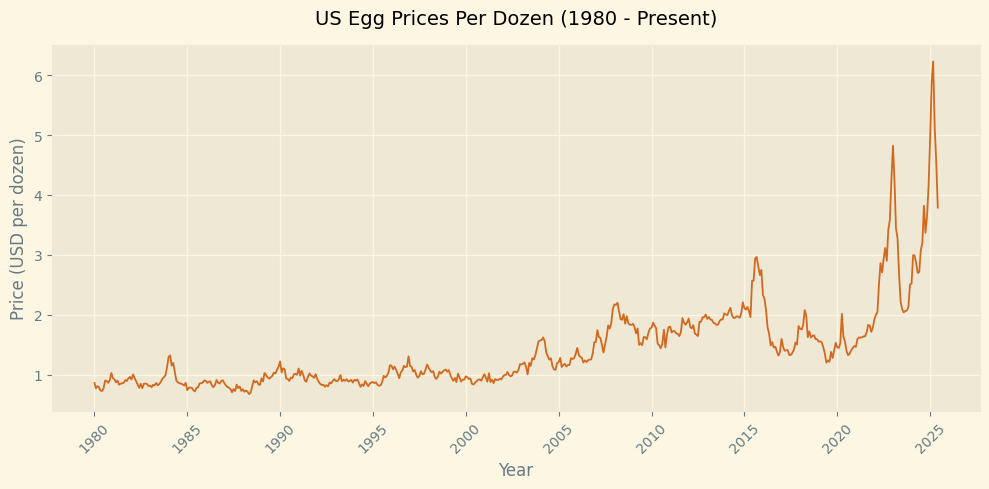

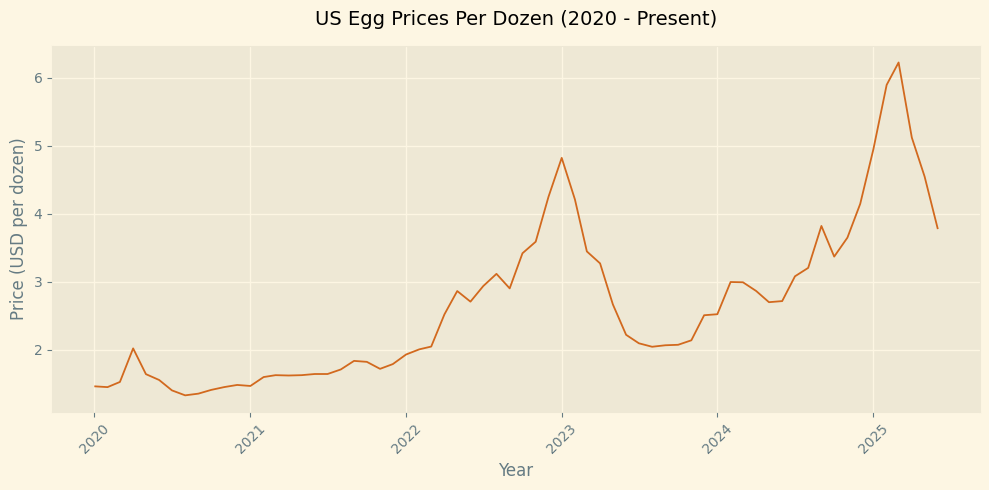

✅ PNG exports saved with rust/orange line colour.


In [18]:

# Load the reformatted CSV
file_path = "../data/usa_data/egg_price_reformatted.csv"
df = pd.read_csv(file_path)

# Parse dates
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", dayfirst=True)
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Clean and sort
df = df.dropna(subset=["Date", "Price"]).sort_values("Date")

# 1️⃣ Full Historical Chart (1980 - Present)
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Price"], color=line_color, linewidth=line_width)
plt.title("US Egg Prices Per Dozen (1980 - Present)", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Price (USD per dozen)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("egg_prices_1980_present.png", dpi=300)  # Save as PNG
#plt.close()
plt.show()

# 2️⃣ Recent Chart (2020 - Present)
df_recent = df[df["Date"] >= "2020-01-01"]
plt.figure(figsize=(10, 5))
plt.plot(df_recent["Date"], df_recent["Price"], color=line_color, linewidth=line_width)
plt.title("US Egg Prices Per Dozen (2020 - Present)", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Price (USD per dozen)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("egg_prices_2020_present.png", dpi=300)  # Save as PNG
#plt.close()
plt.show()

print("✅ PNG exports saved with rust/orange line colour.")


## 2. Ireland Egg Price Analysis

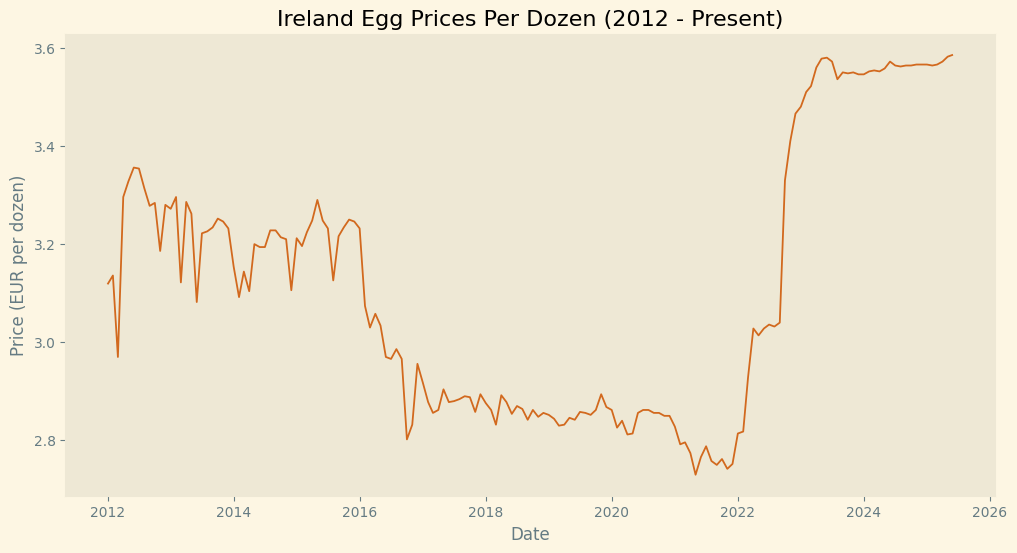

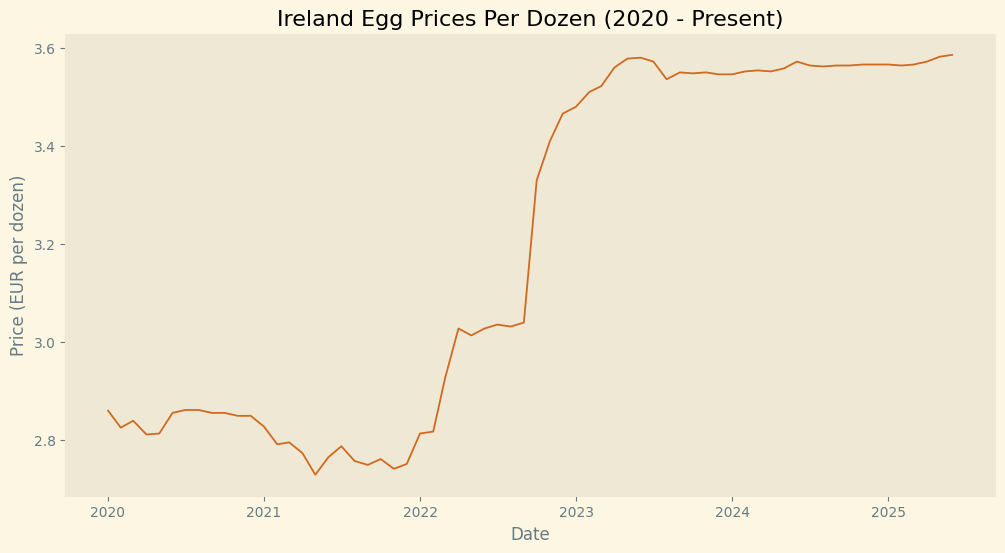

In [19]:

file_path_ie = "../data/ie_data/CPM12.20250802T120846.csv"
df_ie = pd.read_csv(file_path_ie)

# Convert date and price
df_ie["Date"] = pd.to_datetime(df_ie["Month"], format="%Y %B")
df_ie["Price_EUR_Dozen"] = df_ie["VALUE"] * 2
df_ie = df_ie.sort_values("Date")

# Plot full range
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_ie["Date"], df_ie["Price_EUR_Dozen"], color=line_color, linewidth=line_width)
ax.set_title("Ireland Egg Prices Per Dozen (2012 - Present)", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR per dozen)")
ax.grid(False)
plt.show()

# Plot 2020 onwards
df_ie_zoom = df_ie[df_ie["Date"] >= "2020-01-01"]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_ie_zoom["Date"], df_ie_zoom["Price_EUR_Dozen"], color=line_color, linewidth=line_width)
ax.set_title("Ireland Egg Prices Per Dozen (2020 - Present)", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR per dozen)")
ax.grid(False)
plt.show()


## 3. FX Normalisation (EUR to USD)

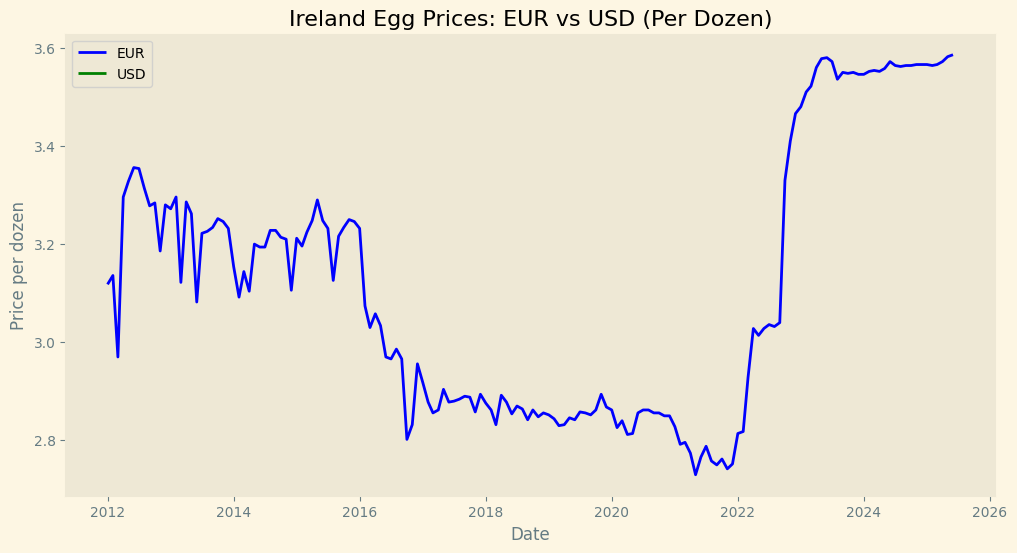

In [20]:

# Load EUR/USD exchange rates
fx_file = "../data/rates/eur_usd.csv"
df_fx = pd.read_csv(fx_file, parse_dates=["Unnamed: 0"])
df_fx.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Merge and calculate USD price
df_ie = pd.merge(df_ie, df_fx, on="Date", how="left")
df_ie["Price_USD_Dozen"] = df_ie["Price_EUR_Dozen"] * df_ie["EUR_USD"]

# Plot EUR vs USD
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_ie["Date"], df_ie["Price_EUR_Dozen"], label="EUR", color="blue")
ax.plot(df_ie["Date"], df_ie["Price_USD_Dozen"], label="USD", color="green")
ax.set_title("Ireland Egg Prices: EUR vs USD (Per Dozen)", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Price per dozen")
ax.legend()
ax.grid(False)
plt.show()
